In [5]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.
import os
import random
import numpy as np
from PIL import Image
from IPython.display import display
import cv2 
import imutils
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt

# Генерация набора данных

### Сгенерировать набор текстовых строк из допустимых символов.

In [6]:
base_dir = 'data'
count = 10

characters = [character if character != 'times' else '*' for character in os.listdir(base_dir)]

def generate_rand_strs(count, chars):
    return [ ''.join(random.choices(chars, k=count)) for _ in range(count) ]

rand_strs = generate_rand_strs(count, characters)
rand_strs

['-*5(t(yyw6',
 'w**ww6w-X0',
 '52h4458*w+',
 '94511157,7',
 '2t7+3(9+8y',
 'h*+t97)+t3',
 '6)+4X65+4-',
 '*8)50(hh00',
 'y94+3yt4)w',
 'X,883*)2*t']


### Каждому набору поставить в соотвествие массив изоражений соответствующих символов.

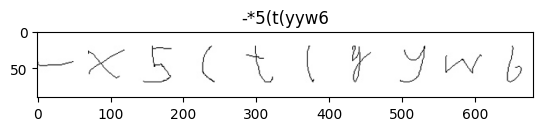

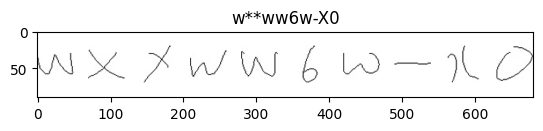

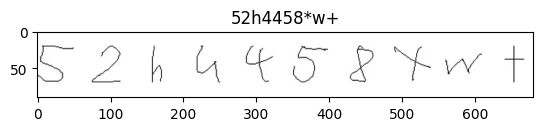

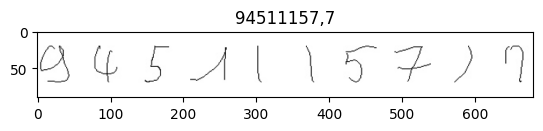

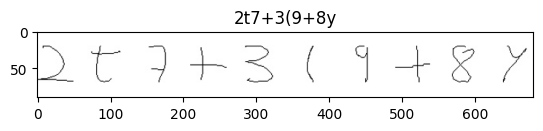

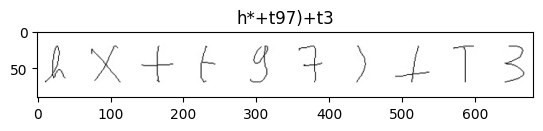

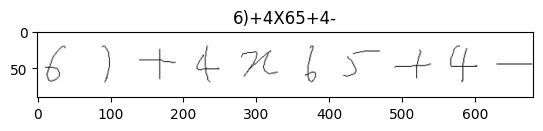

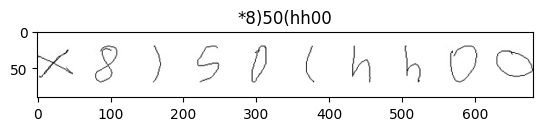

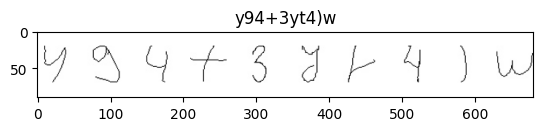

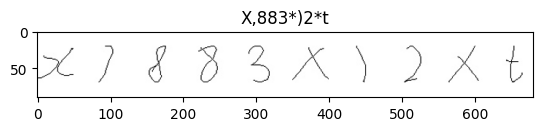

In [7]:
def get_imgs_of_chars(chars):
    images = {}

    for char in chars:
        images[char] = []
        folder = base_dir + f'/{char if char != '*' else 'times'}/'
        images[char] = [ folder + img_file for img_file in os.listdir(folder)]
    
    return images


def map_strs_to_imgs(strs, imgs):
    strs_mapped = {}

    for string in strs:
        strs_mapped[string] = [Image.open(random.choice(imgs[char])).convert('RGB') for char in string]

    return strs_mapped

def create_image_from_str(mapped_str, space=20, height=50, width=50):
    white = (255, 255, 255) 
    total_width = len(mapped_str) * (width + space) - space 
    composite_height = height + 2 * space  

    
    image = Image.new('RGB', (total_width, composite_height), white)

    
    for i, img in enumerate(mapped_str):
        img = img.resize((width, height)) 
        x_offset = i * (width + space)
        y_offset = space
        image.paste(img, (x_offset, y_offset))
    
    return image


images = get_imgs_of_chars(characters)

mapped = map_strs_to_imgs(rand_strs, images)

for rand in rand_strs:
    plt.title(f'{rand}')
    plt.imshow(create_image_from_str(mapped[rand]))
    plt.show()


# КЛАССИФИКАЦИЯ (k ближайших соседей)

### Часть символов оставить для обучения классификатора.
Остальные  классифицировать по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.

In [8]:
def get_X_y(imgs):
    X, y = [], []
    for char in imgs:
        X.extend(list(map(lambda img: np.array(Image.open(img).convert('RGB').resize((50, 50))).flatten(), imgs[char][:len(imgs[char]) // 2])))
        y.extend([char for _ in range(len(imgs[char]) // 2)])

    return X, y

X, y = get_X_y(images)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [28]:
print(len(X), len(y))

112642 112642



### Выбрать оптимальный классификатор в зависимости от k- количество соседей.
Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [29]:
def find_optimal_k(X_train, y_train, range=list(range(1, 5))):
    grid_param = {'n_neighbors': range}
    grid_search_cv = GridSearchCV(KNeighborsClassifier(), grid_param, cv=5, scoring='accuracy', n_jobs=2)
    grid_search_cv.fit(X_train, y_train)

    return grid_search_cv.best_params_['n_neighbors']

opt_k = find_optimal_k(X_train, y_train)

opt_k


1

In [9]:
# first time exec
import joblib


In [12]:

knn = KNeighborsClassifier(n_neighbors=opt_k)
knn.fit(X_train, y_train)
joblib.dump(knn, 'model/knn.pkl')

['model/knn.pkl']

In [10]:
knn = joblib.load('model/knn.pkl')


In [11]:
pred_y = knn.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
accuracy

0.8830370419690614

# Генерация набора данных

### Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.

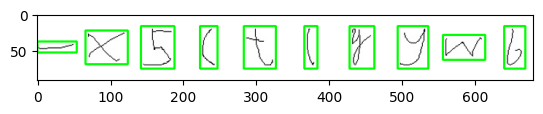

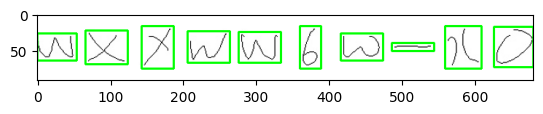

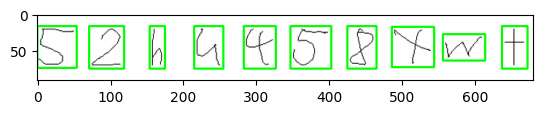

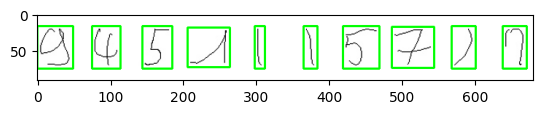

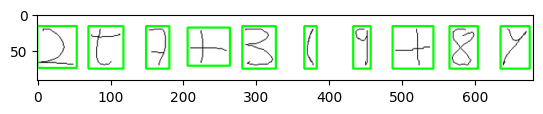

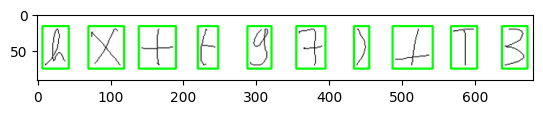

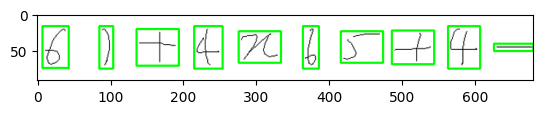

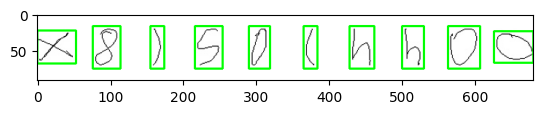

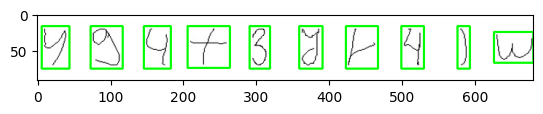

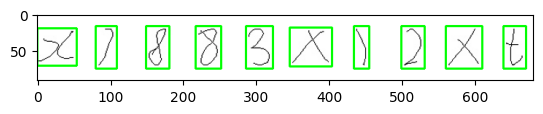

Accuracy: 16.00%


In [14]:
def result(image, model):
    image = np.array(image)

    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    new_image = cv2.threshold(new_image, 128, 255, cv2.THRESH_BINARY_INV)[1]
    new_image = cv2.GaussianBlur(new_image, (7, 7), 5)
    new_image = cv2.dilate(new_image, None, iterations=1)

    contours, _ = cv2.findContours(new_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(c) for c in contours]
    rects.sort(key=lambda rect: rect[0])

    result = []
    fixed_size = (50, 50)
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cropped_region = image[y:y+h, x:x+w]
        resized_region = cv2.resize(cropped_region, fixed_size)
        flattened_region = resized_region.flatten()
        result.append(flattened_region)

    plt.imshow(image)
    plt.show()

    result = np.array(result)
    return model.predict(result)


results, y_test = [], []
for img in mapped:
    results.append(result(create_image_from_str(mapped[img]), knn))
    y_test.extend(img)
    
acc_results = [x for y in results for x in y]
print_results = list(map(lambda x: ''.join(x), results))
accuracy = accuracy_score(y_test, acc_results)
print(f"Accuracy: {accuracy:.2%}")



### Рассчитайте метрику CER.

In [13]:
from cer import calculate_cer
import random

def modify(string):
    result = list(string)
    indices = list(range(0, len(string)))
    random.shuffle(indices)

    for i in indices:
        result[i] = random.choice(string)

    return ''.join(result)

for result in print_results:
    modified = modify(result)

    print(f'original: {result}\n' + \
          f'modified: {modified}\n' + \
          f'cer: {calculate_cer(list(result), list(modified))}')

original: 22221(t722
modified: 222(1t2722
cer: 0.15789473684210525
original: t2,27(75t0
modified: 007t275(20
cer: 0.3157894736842105
original: 2222121*7+
modified: 222122772+
cer: 0.21052631578947367
original: 22(72+5,27
modified: 72(2(2257+
cer: 0.3684210526315789
original: 2t0+22772X
modified: 7tt027X002
cer: 0.2631578947368421
original: (,+(3++111
modified: 1+131++(+3
cer: 0.42105263157894735
original: 6++(222-,5
modified: 22(5,(+6,2
cer: 0.42105263157894735
original: -5+-262+00
modified: 2220-0+2-5
cer: 0.42105263157894735
original: 227-57270t
modified: 7-2-0-7t-2
cer: 0.42105263157894735
original: ,2*222+2,(
modified: ,,((+(*+(2
cer: 0.3684210526315789
